### 1. Load Tweets

In [119]:
import pandas as pd
import numpy as np

In [120]:
file_name = 'vaccine_tweet_en.csv'
df = pd.read_csv(file_name)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17948 entries, 0 to 17947
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   author_id           17948 non-null  int64 
 1   username            17948 non-null  object
 2   author_followers    17948 non-null  int64 
 3   author_tweets       17948 non-null  int64 
 4   author_description  15265 non-null  object
 5   author_location     11799 non-null  object
 6   text                17948 non-null  object
 7   created_at          17948 non-null  object
 8   retweets            17948 non-null  int64 
 9   replies             17948 non-null  int64 
 10  likes               17948 non-null  int64 
 11  quote_count         17948 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 1.6+ MB


### 2. Preprocessing

In [122]:
# Import stopwords
import nltk
from nltk.corpus import stopwords
# Import textblob
from textblob import Word, TextBlob

In [123]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/yuf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yuf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /Users/yuf/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yuf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yuf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [124]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop = set(stopwords.words('english'))
stop.remove('not')

In [138]:
import re

def remove_HTML(text):
    """
    Inputs a string and outputs a string free of any HTML tags
    """
    tag = re.compile(r'<.*?>')
    
    return tag.sub(r'',text)

def remove_URL(text):
    """
    Inputs a string and outputs a string free of any URLs
    """
    url = re.compile(r'https?://\S+|www\.\S+')
    
    return url.sub(r'',text)

def remove_emojis(text):
    """
    Inputs a string and outputs a string free of any emojis
    """
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
    
    return emoji.sub(r'',text)

def remove_punctuations(text):
    """
    Inputs a string and outputs a string free of any punctuations
    """
    punct = re.compile(r'[^\w\s]')
    
    return punct.sub(r'',text)

def remove_stop_words(text):
    """
    inputs a text string and outputs a string without any stopwords
    """
    sentence = [] # list without any stopwords
    for word in text.split():
        if word not in stop:
            sentence.append(word)
            
    return " ".join(sentence)

def lemmatize_words(text):
    return " ".join(Word(word).lemmatize() for word in text.split())


def clean_text(text):
    """
    inputs a string:
    -------------------------------------
    outputs a string free from 
    1) html-tags
    2) urls
    3) emojis
    4) emojis
    5) stopwords
    and lastly corrects the misspelled words
    """
    text = remove_HTML(text)
    text = remove_URL(text)
    text = remove_emojis(text)
    text = remove_punctuations(text)
    text = remove_stop_words(text)
    text = lemmatize_words(text)
    
    return text

In [150]:
# pre-process raw text, get a new column to store processed_text
df['processed_text'] = df['text'].apply(lambda x: clean_text(x))
# convert date_time
df['created_at'] = df['created_at'].apply(lambda x: pd.to_datetime(x))

### 3. Compute Sentiment with TextBlob

In [140]:
# sentiment analysis, get two new columns specifying polarity and subjectivity
df['polarity'] = df['processed_text'].apply(lambda x: TextBlob(x).sentiment[0])
df['subjectivity'] = df['processed_text'].apply(lambda x: TextBlob(x).sentiment[1])

In [131]:
df[['polarity', 'subjectivity', 'retweets', 'likes']].agg([np.mean, np.median, np.max, np.min])

,polarity,subjectivity,retweets,likes
mean,0.082512,0.303087,128.623468,1.502062
median,0.000000,0.300000,5.000000,0.000000
amax,1.000000,1.000000,2354.000000,2121.000000
amin,-1.000000,0.000000,0.000000,0.000000


### 4. Visualization
1. We check the trends of Polarity / Subjectivity through the five-days period.
2. We check the relationship between number of retweets to Polarity/Subjectivity.

In [179]:
from matplotlib import pyplot as plt

In [160]:
dfv = df.sort_values('created_at')[['created_at', 'polarity', 'subjectivity', 'retweets', 'likes']]

In [176]:
polar = dfv.polarity.rolling(100, min_periods=10).mean()
subj = dfv.subjectivity.rolling(100, min_periods=10).mean()

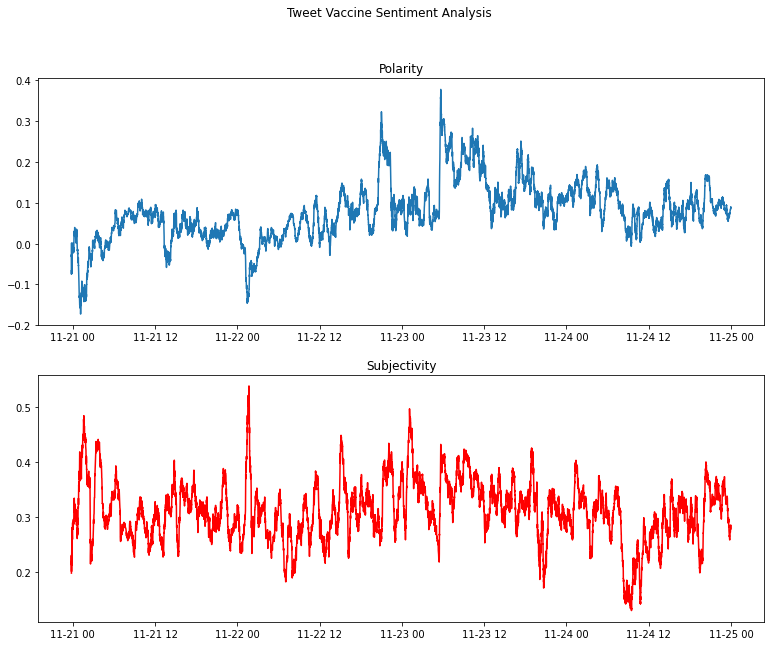

In [180]:
fig, axes = plt.subplots(2, 1, figsize=(13, 10))

axes[0].plot(dfv.created_at, polar)
axes[0].set_title("\n".join(["Polarity"]))
axes[1].plot(dfv.created_at, subj, color='red')
axes[1].set_title("\n".join(["Subjectivity"]))

fig.suptitle("\n".join(["Tweet Vaccine Sentiment Analysis"]), y=0.98)

plt.show()

In [193]:
# get the sentiment connected to number of retweets
dfrt = dfv.groupby('retweets').agg(np.mean)

In [201]:
polar = dfrt.polarity.rolling(5, min_periods=2).mean()
subj = dfrt.subjectivity.rolling(5, min_periods=2).mean()

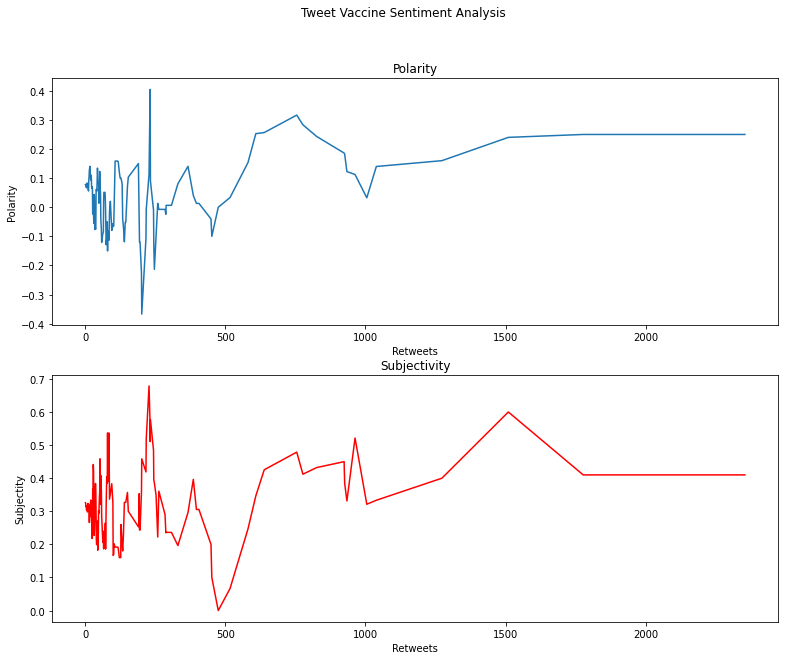

In [202]:
fig, axes = plt.subplots(2, 1, figsize=(13, 10))

axes[0].plot(polar)
axes[0].set_title("\n".join(["Polarity"]))
axes[0].set_xlabel('Retweets')
axes[0].set_ylabel('Polarity')
axes[1].plot(subj, color='red')
axes[1].set_title("\n".join(["Subjectivity"]))
axes[1].set_xlabel('Retweets')
axes[1].set_ylabel('Subjectity')

fig.suptitle("\n".join(["Tweet Vaccine Sentiment Analysis"]), y=0.98)

plt.show()